In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
df = pd.read_csv('churn.csv',index_col=0)
df =df.replace('?','0')
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,0,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,0,...,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,0,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.9,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [2]:
df.columns

Index(['State', 'Account Length', 'Area Code', 'Phone', 'Int'l Plan',
       'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge',
       'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls',
       'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge',
       'CustServ Calls', 'Churn?'],
      dtype='object')

In [3]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Isolate target data
churn_result = df['Churn?']
y = np.where(churn_result == 'True.',1,0)
# y = df.iloc[:, 20].values
# labelencoder_y = LabelEncoder()
# y = labelencoder_y.fit_transform(y)
# df['Churn'] = (df['Churn?'] == 'True.')
# y = df['Churn'].as_matrix().astype(np.int)
print('There are {} instances for churn class and {} instances for not-churn classes.'.format(y.sum(), y.shape[0] - y.sum()))
print('Ratio of churn class over all instances: {:.2f}'.format(float(y.sum()) / y.shape[0]))

There are 483 instances for churn class and 2850 instances for not-churn classes.
Ratio of churn class over all instances: 0.14


In [4]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

df2 = df

# We don't need these columns
to_drop = ['State','Area Code','Phone','Churn?']
churn_feat_space = df.drop(to_drop,axis=1)

# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
yes_no_cols = ["Int'l Plan","VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

# Pull out features for future use
features = churn_feat_space.columns
X = churn_feat_space.as_matrix().astype(np.float)

# State is string and we want discre integer values
# labelencoder = LabelEncoder()
# df2['State'] = labelencoder.fit_transform(df2['State'])
# Drop the redundant columns from dataframe
# df2.drop(['Area Code','Phone','Churn','Churn?'], axis=1, inplace=True)
# Get the features as integers similar to what we did for labels(targets)
# df2[["Int'l Plan","VMail Plan"]] = df2[["Int'l Plan","VMail Plan"]] == 'yes'
# df2.head(100)

# labelencoder_X_1 = LabelEncoder()
# X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])
# labelencoder_X_2 = LabelEncoder()
# X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])
# onehotencoder = OneHotEncoder(categorical_features = [1])
# X = onehotencoder.fit_transform(X).toarray()
# X = X[:, 1:]


In [5]:
# This is important
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

print("Feature space holds %d observations and %d features", X.shape)
print ("Unique target labels:", np.unique(y))      

Feature space holds %d observations and %d features (3333, 17)
Unique target labels: [0 1]


In [6]:
# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)
# sc_y = StandardScaler()
# y = sc_y.fit_transform(y)

X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
# y_train = sc_X.fit_transform(y_train)


/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
from sklearn.cross_validation import KFold
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()

    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

In [8]:
def stratified_cv(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = cross_validation.StratifiedKFold(y, n_folds=n_folds, shuffle=shuffle)
    y_pred = y.copy()
    for ii, jj in stratified_k_fold:
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[jj] = clf.predict(X_test)
    return y_pred

In [9]:
from sklearn.metrics import accuracy
from sklearn import metrics
from sklearn import cross_validation
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import preprocessing
from xgboost import XGBClassifier

print('Dump Classifier:               {:.3f}'.format(accuracy(y, [0 for ii in y.tolist()])))
print('Passive Aggressive Classifier: {:.3f}'.format(accuracy(y, run_cv(X, y, linear_model.PassiveAggressiveClassifier))))
print('Ridge Classifier:              {:.3f}'.format(accuracy(y, run_cv(X, y, linear_model.RidgeClassifier))))
print('Logistic Regression:           {:.3f}'.format(accuracy(y, run_cv(X, y, linear_model.LogisticRegression))))
print('K Nearest Neighbor Classifier: {:.3f}'.format(accuracy(y, run_cv(X, y, neighbors.KNeighborsClassifier))))
print('Support vector machine(SVM):   {:.3f}'.format(accuracy(y, run_cv(X, y, svm.SVC))))
print('Decision Tree Classifier:      {:.3f}'.format(accuracy(y, run_cv(X, y, tree.DecisionTreeClassifier))))
print('Random Forest Classifier:      {:.3f}'.format(accuracy(y, run_cv(X, y, ensemble.RandomForestClassifier))))
print('Gradient Boosting Classifier:  {:.3f}'.format(accuracy(y, run_cv(X, y, ensemble.GradientBoostingClassifier))))
print('XGBoost:                       {:.3f}'.format(accuracy(y, run_cv(X, y, XGBClassifier))))

Dump Classifier:               0.86
Passive Aggressive Classifier: 0.85
Ridge Classifier:              0.86
Logistic Regression:           0.86
K Nearest Neighbor Classifier: 0.88
Support vector machine(SVM):   0.91
Decision Tree Classifier:      0.90
Random Forest Classifier:      0.93
Gradient Boosting Classifier:  0.94
XGBoost:                       0.94


In [10]:


print('Dump Classifier:               {:.3f}'.format(accuracy_score(y, [0 for ii in y.tolist()])))
print('Passive Aggressive Classifier: {:.3f}'.format(accuracy_score(y, stratified_cv(X, y, linear_model.PassiveAggressiveClassifier))))
print('Ridge Classifier:              {:.3f}'.format(accuracy_score(y, stratified_cv(X, y, linear_model.RidgeClassifier))))
print('Logistic Regression:           {:.3f}'.format(accuracy_score(y, stratified_cv(X, y, linear_model.LogisticRegression))))
print('K Nearest Neighbor Classifier: {:.3f}'.format(accuracy_score(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))))
print('Support vector machine(SVM):   {:.3f}'.format(accuracy_score(y, stratified_cv(X, y, svm.SVC))))
print('Decision Tree Classifier:      {:.3f}'.format(accuracy_score(y, stratified_cv(X, y, tree.DecisionTreeClassifier))))
print('Random Forest Classifier:      {:.3f}'.format(accuracy_score(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))
print('Gradient Boosting Classifier:  {:.3f}'.format(accuracy_score(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))))
print('XGBoost:                       {:.3f}'.format(accuracy_score(y, stratified_cv(X, y, XGBClassifier))))

Dump Classifier:               0.86
Passive Aggressive Classifier: 0.79
Ridge Classifier:              0.86
Logistic Regression:           0.86
K Nearest Neighbor Classifier: 0.89
Support vector machine(SVM):   0.91
Decision Tree Classifier:      0.90
Random Forest Classifier:      0.93
Gradient Boosting Classifier:  0.94
XGBoost:                       0.94


In [11]:
dumb_conf_matrix = metrics.confusion_matrix(y, [0 for ii in y.tolist()]); # ignore the warning as they are all 0
pass_agg_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, linear_model.PassiveAggressiveClassifier))
ridge_clf_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, linear_model.RidgeClassifier))
logistic_reg_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, linear_model.LogisticRegression))
k_neighbors_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))
svm_svc_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, svm.SVC))
decision_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, tree.DecisionTreeClassifier))
random_forest_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, ensemble.RandomForestClassifier))
grad_ens_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))
XGB_ens_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, XGBClassifier))

In [12]:
print('Dump Classifier:\n {}\n'.format(metrics.classification_report(y, [0 for ii in y.tolist()]))); # ignore the warning as they are all 0
print('Passive Aggressive Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, linear_model.PassiveAggressiveClassifier))))
print('Logistic Regression:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, linear_model.LogisticRegression))))
print('Support vector machine(SVM):\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, svm.SVC))))
print('Random Forest Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))
print('K Nearest Neighbor Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))))
print('Gradient Boosting Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))))



/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Dump Classifier:
              precision    recall  f1-score   support

          0       0.86      1.00      0.92      2850
          1       0.00      0.00      0.00       483

avg / total       0.73      0.86      0.79      3333


Passive Aggressive Classifier:
              precision    recall  f1-score   support

          0       0.89      0.88      0.88      2850
          1       0.33      0.35      0.34       483

avg / total       0.81      0.80      0.80      3333


Logistic Regression:
              precision    recall  f1-score   support

          0       0.88      0.97      0.92      2850
          1       0.54      0.19      0.28       483

avg / total       0.83      0.86      0.83      3333


Support vector machine(SVM):
              precision    recall  f1-score   support

          0       0.91      0.99      0.95      2850
          1       0.87      0.46      0.60       483

avg / total       0.91      0.91      0.90      3333


Random Forest Classifier:
        

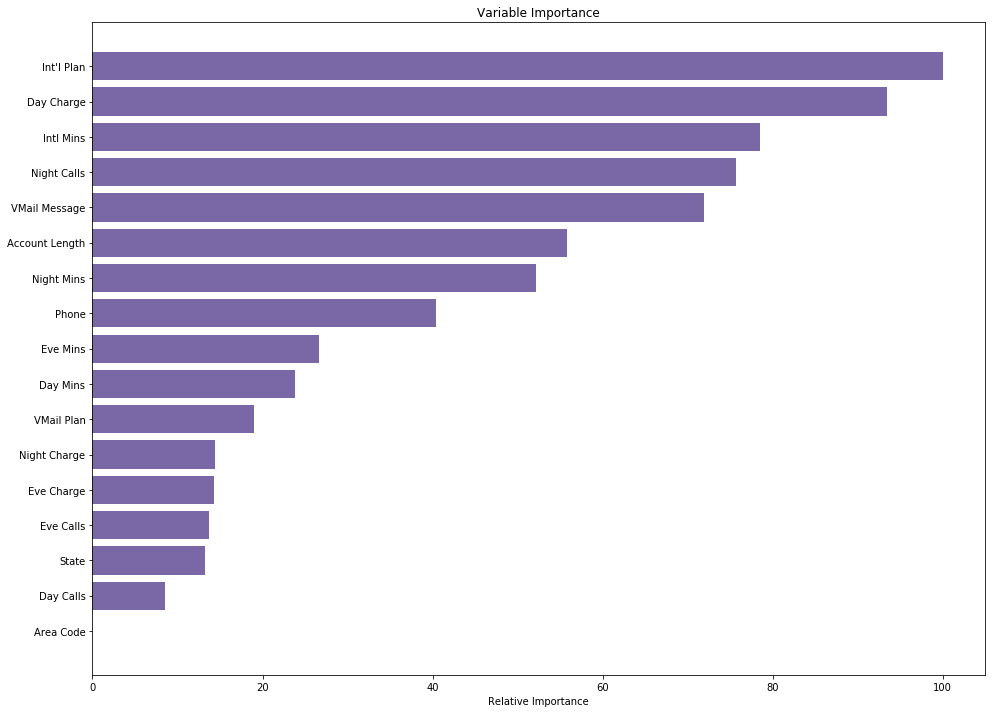

In [13]:
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X, y)
# Get Feature Importance from the classifier
feature_importance = gbc.feature_importances_
# Normalize The Features
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(16, 12))
plt.barh(pos, feature_importance[sorted_idx], align='center', color='#7A68A6')
plt.yticks(pos, np.asanyarray(df.columns.tolist())[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [14]:
X = df.as_matrix().astype(np.float)
polynomial_features = preprocessing.PolynomialFeatures()
X = polynomial_features.fit_transform(X)

ValueError: could not convert string to float: 'False.'

In [ ]:
print('Passive Aggressive Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, linear_model.PassiveAggressiveClassifier))))
print('Gradient Boosting Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))))
print('Support vector machine(SVM):\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, svm.SVC))))
print('Random Forest Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))
print('K Nearest Neighbor Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))))
print('Logistic Regression:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, linear_model.LogisticRegression))))
print('Dump Classifier:\n {}\n'.format(metrics.classification_report(y, [0 for ii in y.tolist()]))); # ignore the warning as they are all 0

In [ ]:
X = df.as_matrix().astype(np.float)
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
polynomial_features = preprocessing.PolynomialFeatures()
X = polynomial_features.fit_transform(X)

In [ ]:
print('Passive Aggressive Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, linear_model.PassiveAggressiveClassifier))))
print('Gradient Boosting Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))))
print('Support vector machine(SVM):\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, svm.SVC))))
print('Random Forest Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))
print('K Nearest Neighbor Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))))
print('Logistic Regression:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, linear_model.LogisticRegression))))
print('Dump Classifier:\n {}\n'.format(metrics.classification_report(y, [0 for ii in y.tolist()]))); # ignore the warning as they are all 0

In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_pred)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X, y = y, cv = 10)
accuracies.mean()
accuracies.std()